In [1]:
%load_ext autoreload
%autoreload 2

# guidelines

TODO : import whenever needed, not centralized

states https://pytorch.org/tutorials/beginner/saving_loading_models.html

# Introduction 

## Aim

## Data

First load the dataset:

In [2]:
from data_utils import get_mnist

train_dataset, test_dataset = get_mnist(normalize=True)

In [3]:
import numpy as np
#import random
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Setup

Below one can find flags that will setup the notebook:

In [4]:
# Whether to tune the hyperparameters in this notebook
# Note that this might take a long time (especially for Adam)
hyperparameter_tune = False
prot_hyperparameter_tune = False

In [5]:
# Whether to use the GPU, if it's not available, this will be ignored
use_cuda = True
device = torch.device('cuda' if use_cuda and torch.cuda.is_available() else 'cpu')
print("Device chosen is {}".format(device))

Device chosen is cuda


We setup the training parameters that we will use all along the notebook, in order to improve readability in downstream code:

In [10]:
from training import accuracy

training_config = {
    # Loss function
    'loss_fun': torch.nn.CrossEntropyLoss(),
    # Performance evaluation function
    'metric_fun': accuracy,
    # The device to train on
    'device': device,
    # Number of epochs
    'epochs': 10,
}

test_config = training_config.copy()
test_config.pop('epochs');

Note that we will use a model with a 10-dimensional output, where each output is passed through softmax. When receiving an output 

$$Z = \begin{bmatrix} \mathbf z_1 & \dots & \mathbf z_B \end{bmatrix}^\top \in \mathbb R^{B \times 10}$$

with $B$ the batch size, we first retrieve the maximal component of each $\mathbf z_i$:

$$\hat y_i = \text{argmax}_{k = 1, \ldots, 10} \; z_{ik}, \quad i = 1, \ldots, B$$

and then compute the accuracy:

$$\text{acc} = \frac 1 B \sum_{i=1}^B I\left\{ \hat y_i = y_i \right\} $$

with $I$ the indicator function and $y_i \in \{1, \ldots, 10\}$ the true target. 

In [11]:
# View the source code
??accuracy

Signature: accuracy(yhat, y)
Docstring: <no docstring>
Source:   
def accuracy(yhat, y):
    prediction = yhat.argmax(dim=1)
    return (y.eq(prediction)).to(float).mean().item()
File:      /media/maousi/Data/Documents/Programmation/courses/DS-MA2/optml_project/training.py
Type:      function


# Model

We use a simple standard model for the MNIST dataset (can be found [here](https://github.com/floydhub/mnist/blob/master/ConvNet.py)).

In [12]:
from net import Net

??Net

Init signature: Net()
Source:        
class Net(nn.Module):
    """ConvNet -> Max_Pool -> RELU -> ConvNet -> Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
File:           /media/maousi/Data/Documents/Programmation/courses/DS-MA2/optml_project/net.py
Type:           type
Subclasses:     


# Hyperparameter tuning

In [13]:
from torch.optim import Optimizer
from training import tune_optimizer
from optimizer import AdamOptimizer, NesterovOptimizer, MiniBatchOptimizer
from data_utils import get_best_hyperparams

If the `hyperparameter_tune` flag was set to `True` above, the following code will run hyperparameter tuning on all optimizers. Note that one can either run KFold cross validation (by providing `n_folds`) or use a simple train/test split (by providing `train_ratio`).

If the flag is set to `False`, the cell below will simply set up the hyperparameters that we carefully cross-validated:

In [14]:
optimizers = {
    AdamOptimizer: get_best_hyperparams('./res/adam_tuning_round3.json'),
    NesterovOptimizer: get_best_hyperparams('./res/nesterov_tuning_round2.json'),
    MiniBatchOptimizer: get_best_hyperparams('./res/minibatch_tuning_round2.json')
}

## Adam

In [15]:
search_grid_adam = {
        'lr': np.linspace(0.001, 0.01, 2),
        'beta1':  np.linspace(0.1, 0.9, 2),
        'beta2': np.linspace(0.5, 0.999, 2),
        'batch_size': [32, 64, 128],
        'weight_decay': np.linspace(0.001, 0.1, 2),
        'epsilon': np.linspace(1e-10, 1e-8, 2),
    }

if hyperparameter_tune:
    results_adam = tune_optimizer(
        model=Net().to(device),
        optim_fun=AdamOptimizer,
        xtrain=train_dataset.data,
        ytrain=train_dataset.targets,
        search_grid=search_grid_adam,
        nfolds=3,
        **training_config)

else:
    results_adam = optimizers[AdamOptimizer]

## Nesterov

In [16]:
search_grid_nesterov = {
    'lr': np.logspace(0, 1),
    'batch_size': [32, 64, 128]
}

if hyperparameter_tune:
    results_nesterov = tune_optimizer(
        model=Net().to(device),
        optim_fun=NesterovOptimizer,
        xtrain=train_dataset.data,
        ytrain=train_dataset.targets,
        search_grid=search_grid_nesterov,
        nfolds=3,
        **training_config
    )

else:
    results_nesterov = optimizers[NesterovOptimizer]

## Minibatch

In [17]:
search_grid_mini  = {
    'lr': np.linspace(0.00001, 0.01, 5),
    'batch_size': [32, 64, 128],
    'decreasing_lr': [0, 1],
}
if hyperparameter_tune:
    results_mini = tune_optimizer(
        model=Net().to(device),
        optim_fun=MiniBatchOptimizer,
        xtrain=train_dataset.data,
        ytrain=train_dataset.targets,
        search_grid=search_grid_mini,
        nfolds=3,
        **training_config
    )

else:
    results_mini = optimizers[MiniBatchOptimizer]

In [18]:
print("ADAM: Highest Test Accuracy {:.4f} with standart deviation of {:.4f}".format(results_adam["metric_test"], results_adam["metric_test_std"]))
print("Hyperparameter set: Learning rate =  {:.4f}, Beta1 = {:.1f}, Beta2 = {:.3f}, Weight decay = {:.2f}, Epsilon = {:.8f},  Batch Size = {:.0f}\n".format(results_adam["lr"], results_adam["beta1"], results_adam["beta2"], results_adam["weight_decay"], results_adam["epsilon"], results_adam['batch_size']))
print("NESTEROV: Highest Test Accuracy {:.4f} with standart deviation of {:.4f}".format(results_nesterov["metric_test"], results_nesterov["metric_test_std"]))
print("Hyperparameter set: Learning rate =  {:.4f}, Batch Size = {:.0f}\n".format(results_nesterov["lr"], results_nesterov["batch_size"]))
print("MINIBATCH: Highest Test Accuracy {:.4f} with standart deviation of {:.4f}".format(results_mini["metric_test"], results_mini["metric_test_std"]))
print("Hyperparameter set: Learning rate =  {:.4f}, Decreasing Learning rate {:.1f}, Batch Size = {:.0f}\n".format(results_mini["lr"], results_mini["decreasing_lr"], results_mini["batch_size"]))


ADAM: Highest Test Accuracy 0.9868 with standart deviation of 0.0007
Hyperparameter set: Learning rate =  0.0001, Beta1 = 0.9, Beta2 = 0.999, Weight decay = 0.01, Epsilon = 0.00000001,  Batch Size = 32

NESTEROV: Highest Test Accuracy 0.9876 with standart deviation of 0.0010
Hyperparameter set: Learning rate =  0.0001, Batch Size = 64

MINIBATCH: Highest Test Accuracy 0.9886 with standart deviation of 0.0002
Hyperparameter set: Learning rate =  0.2639, Decreasing Learning rate 0.0, Batch Size = 128



# Attack on naive model



In [19]:
from data_utils import build_data_loaders
from training import training, testing
from adversary import attack, projected_attack

In [20]:
optimizers = {
    AdamOptimizer: get_best_hyperparams('./res/adam_tuning_round3.json', get_performance=False),
    NesterovOptimizer: get_best_hyperparams('./res/nesterov_tuning_round2.json', get_performance=False),
    MiniBatchOptimizer: get_best_hyperparams('./res/minibatch_tuning_round2.json', get_performance=False)
}

In [22]:
optimizers[AdamOptimizer]['batch_size'] = 128

In [24]:
training_config['epochs'] = 3

In [25]:
# Logging data structures
data_naive = list()
data_naive_attack = list()

# Training / attack config
n_try = 3
batch_log_interval = -1
epsilons = np.arange(0, 0.6, 0.05)

for optimizer, optimizer_params in optimizers.items():
    print(f'--- {optimizer.__name__}')
    # --------- SETUP OPTIMIZER
    optimizer_params = optimizer_params.copy()
    # Instantiate data loaders with selected batch size
    batch_size = int(optimizer_params.pop('batch_size'))
    train_loader, test_loader = build_data_loaders(train_dataset, test_dataset, batch_size)
    
    # --------- Train & Attack several times per optimizer
    for n in range(1, n_try + 1):
        net = Net().to(device)
        optimizer_instance = optimizer(net.parameters(), **optimizer_params)
        # --------- TRAIN MODEL
        loss_train, acc_train = training(
            model=net, 
            dataset=train_loader, 
            optim=optimizer_instance,
            batch_log_interval=batch_log_interval,
            **training_config
        )
        # --------- TEST MODEL
        loss_test, acc_test = testing(
            model=net,
            dataset=test_loader,
            **test_config
        )
        # Log
        data_naive.append({
            'optimizer': str(optimizer_instance),
            'n': n,
            'loss_train': loss_train,
            'acc_train': acc_train,
            'loss_test': loss_test,
            'acc_test': acc_test
        })

        # --------- ATTACK MODEL
        print(f'Launching attacks', end=' ')
        for eps in epsilons:
            print('', end='.')
            loss_attack, acc_attack = attack(
                model=net,
                test_loader=test_loader,
                epsilon=eps,
                verbose=False,
                **test_config
            )
            # Log
            data_naive_attack.append({
                'optimizer': str(optimizer_instance),
                'n': n,
                'epsilon': eps,
                'loss': loss_attack,
                'acc': acc_attack
            })

        print()

--- AdamOptimizer
Launching training on cuda . . . training took 4.207 s
Avg test loss = 0.146	Avg test acc = 0.955
Launching attacks ............
Launching training on cuda . . . training took 4.207 s
Avg test loss = 0.137	Avg test acc = 0.958
Launching attacks ............
Launching training on cuda . . . training took 3.955 s
Avg test loss = 0.135	Avg test acc = 0.96
Launching attacks ............
--- NesterovOptimizer
Launching training on cuda . . . training took 5.465 s
Avg test loss = 0.0629	Avg test acc = 0.979
Launching attacks ............
Launching training on cuda . . . training took 5.48 s
Avg test loss = 0.0642	Avg test acc = 0.979
Launching attacks ............
Launching training on cuda . . . training took 5.544 s
Avg test loss = 0.0718	Avg test acc = 0.977
Launching attacks ............
--- MiniBatchOptimizer
Launching training on cuda . . . training took 3.032 s
Avg test loss = 0.0378	Avg test acc = 0.987
Launching attacks ............
Launching training on cuda . . .

### Training curves

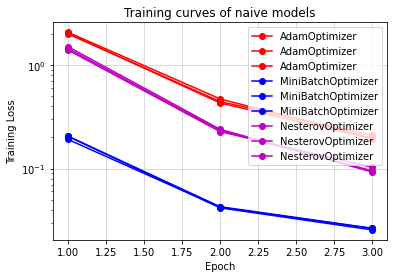

In [26]:
df_naive = pd.DataFrame(data_naive).sort_values(['optimizer', 'n'])
# Average training loss per epoch
df_naive.loss_train = df_naive.loss_train.apply(lambda s: np.mean(s, axis=1))

colors = {'AdamOptimizer': 'r', 'MiniBatchOptimizer': 'b', 'NesterovOptimizer': 'm'}
for _, row in df_naive.iterrows():
    plt.plot(range(1, training_config['epochs'] + 1), row.loss_train, '-o', label=row.optimizer, color=colors[row.optimizer])

plt.grid(alpha=.6)
plt.legend();
plt.yscale('log')
plt.xlabel('Epoch'); plt.ylabel('Training Loss')
plt.title('Training curves of naive models');

### Attack plots

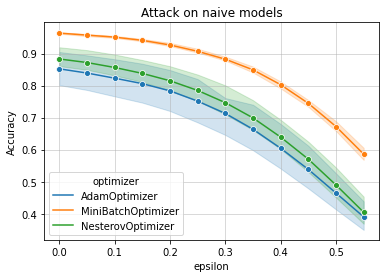

In [41]:
df = pd.DataFrame(data_naive_attack).sort_values(['optimizer', 'epsilon'])
# Raw accuracy in function of attack stength
sns.lineplot(x='epsilon', y='acc', data=df, hue='optimizer', marker='o')
plt.grid(alpha=.6)
plt.ylabel('Accuracy');
plt.title('Attack on naive models');

In [48]:
df.T.to_json('res/log_attack_naive.json', indent=2)

# Attack on robust model

## Hyperparameter optimization on robust models

- If the `prot_hyperparameter_tune` flag was set to `True` above, the following code will run hyperparameter tuning on all optimizers for robust models. Note that one can either run KFold cross validation (by providing `n_folds`) or use a simple train/test split (by providing `train_ratio`).


In [29]:
prot_optimizers = {
    AdamOptimizer: get_best_hyperparams('./res/prot_adam_tuning.json', get_performance=False),
    NesterovOptimizer: get_best_hyperparams('./res/prot_nesterov_tuning.json', get_performance=False),
    MiniBatchOptimizer: get_best_hyperparams('./res/prot_minibatch_tuning.json', get_performance=False)
}

### Adam

In [30]:
search_grid_adam = {
        'lr': np.linspace(0.001, 0.01, 2),
        'beta1':  np.linspace(0.1, 0.9, 2),
        'beta2': np.linspace(0.5, 0.999, 2),
        'batch_size': [32, 64, 128],
        'weight_decay': np.linspace(0.001, 0.1, 2),
        'epsilon': np.linspace(1e-10, 1e-8, 2),
    }

if prot_hyperparameter_tune:
    results_adam_prot = tune_optimizer(
        model=Net().to(device),
        optim_fun=AdamOptimizer,
        xtrain=train_dataset.data,
        ytrain=train_dataset.targets,
        search_grid=search_grid_adam,
        nfolds=3,
        func=protected_training,
        **training_config)

else:
    results_adam_prot = optimizers[AdamOptimizer]

### Nesterov

In [31]:
search_grid_nesterov = {
    'lr': np.logspace(0, 1),
    'batch_size': [32, 64, 128]
}

if hyperparameter_tune:
    results_nesterov_prot = tune_optimizer(
        model=Net().to(device),
        optim_fun=NesterovOptimizer,
        xtrain=train_dataset.data,
        ytrain=train_dataset.targets,
        search_grid=search_grid_nesterov,
        nfolds=3,
        func=protected_training,
        **training_config
    )

else:
    results_nesterov_prot = optimizers[NesterovOptimizer]

### Minibatch

In [32]:
search_grid_mini  = {
        'lr': np.linspace(0.00001, 0.01, 5),
        'batch_size': [32, 64, 128],
        'decreasing_lr': [0, 1],
    }
if hyperparameter_tune:
    results_mini_prot = tune_optimizer(
        model=Net().to(device),
        optim_fun=MiniBatchOptimizer,
        xtrain=train_dataset.data,
        ytrain=train_dataset.targets,
        search_grid=search_grid_mini,
        nfolds=3,
        func=protected_training,
        **training_config
    )

else:
    results_mini_prot = optimizers[MiniBatchOptimizer]

## Train & Attack robust models

In [34]:
from adversary import protected_training

In [49]:
# Logging data structures
data_robust = list()
data_robust_attack = list()

# Training / attack config
n_try = 3
batch_log_interval = -1
epsilons = np.arange(0, 0.6, 0.05)

for optimizer, optimizer_params in prot_optimizers.items():
    print(f'--- {optimizer.__name__}')
    # --------- SETUP OPTIMIZER
    optimizer_params = optimizer_params.copy()
    # Instantiate data loaders with selected batch size
    batch_size = int(optimizer_params.pop('batch_size'))
    train_loader, test_loader = build_data_loaders(train_dataset, test_dataset, batch_size)

    # --------- Train & Attack several times per optimizer
    for n in range(1, n_try + 1):
        net = Net().to(device)
        optimizer_instance = optimizer(net.parameters(), **optimizer_params)
        # --------- TRAIN MODEL
        loss_train, acc_train = protected_training(
            model=net,
            dataset=train_loader,
            optim=optimizer_instance,
            batch_log_interval=batch_log_interval,
            **training_config
        )
        # --------- TEST MODEL
        loss_test, acc_test = testing(
            model=net,
            dataset=test_loader,
            **test_config
        )
        # Log
        data_robust.append({
            'optimizer': str(optimizer_instance),
            'n': n,
            'loss_train': loss_train,
            'acc_train': acc_train,
            'loss_test': loss_test,
            'acc_test': acc_test
        })

        # --------- ATTACK MODEL
        print(f'Launching attacks', end=' ')
        for eps in epsilons:
            print('', end='.')
            loss_attack, acc_attack = attack(
                model=net,
                test_loader=test_loader,
                epsilon=eps,
                verbose=False,
                **test_config
            )
            # Log
            data_robust_attack.append({
                'optimizer': str(optimizer_instance),
                'n': n,
                'epsilon': eps,
                'loss': loss_attack,
                'acc': acc_attack
            })

        print()

--- AdamOptimizer
. . . training took 10.97 s
Avg test loss = 0.149	Avg test acc = 0.977
Launching attacks ............
. . . training took 10.88 s
Avg test loss = 0.13	Avg test acc = 0.979
Launching attacks ............
. . . training took 10.65 s
Avg test loss = 0.237	Avg test acc = 0.964
Launching attacks ............
--- NesterovOptimizer
. . . training took 9.022 s
Avg test loss = 0.124	Avg test acc = 0.974
Launching attacks ............
. . . training took 8.857 s
Avg test loss = 0.214	Avg test acc = 0.959
Launching attacks ............
. . . training took 9.385 s
Avg test loss = 0.136	Avg test acc = 0.972
Launching attacks ............
--- MiniBatchOptimizer
. . . training took 5.235 s
Avg test loss = 0.103	Avg test acc = 0.976
Launching attacks ............
. . . training took 5.338 s
Avg test loss = 0.0863	Avg test acc = 0.98
Launching attacks ............
. . . training took 5.295 s
Avg test loss = 0.119	Avg test acc = 0.973
Launching attacks ............


In [50]:
df_robust = pd.DataFrame(data_robust_attack)
df_robust

,optimizer,n,epsilon,loss,acc
0,AdamOptimizer,1,0.00,"[0.014005744829773903, 0.12235231697559357, 0....",0.985470
1,AdamOptimizer,1,0.05,"[0.014005744829773903, 0.12235231697559357, 0....",0.983380
2,AdamOptimizer,1,0.10,"[0.014005744829773903, 0.12235231697559357, 0....",0.980494
3,AdamOptimizer,1,0.15,"[0.014005744829773903, 0.12235231697559357, 0....",0.977408
4,AdamOptimizer,1,0.20,"[0.014005744829773903, 0.12235231697559357, 0....",0.971139
...,...,...,...,...,...
103,MiniBatchOptimizer,3,0.35,"[0.04023260250687599, 0.15168392658233643, 0.0...",0.920985
104,MiniBatchOptimizer,3,0.40,"[0.04023260250687599, 0.15168392658233643, 0.0...",0.904668
105,MiniBatchOptimizer,3,0.45,"[0.04023260250687599, 0.15168392658233643, 0.0...",0.879945
106,MiniBatchOptimizer,3,0.50,"[0.04023260250687599, 0.15168392658233643, 0.0...",0.844244


### Training curves

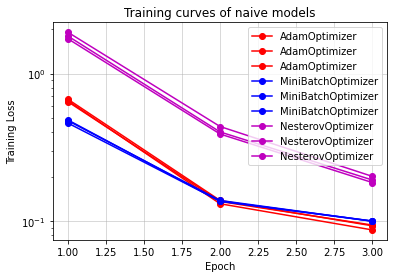

In [51]:
df_naive = pd.DataFrame(data_robust).sort_values(['optimizer', 'n'])
# Average training loss per epoch
df_naive.loss_train = df_naive.loss_train.apply(lambda s: np.mean(s, axis=1))

colors = {'AdamOptimizer': 'r', 'MiniBatchOptimizer': 'b', 'NesterovOptimizer': 'm'}
for _, row in df_naive.iterrows():
    plt.plot(range(1, training_config['epochs'] + 1), row.loss_train, '-o', label=row.optimizer, color=colors[row.optimizer])

plt.grid(alpha=.6)
plt.legend();
plt.yscale('log')
plt.xlabel('Epoch'); plt.ylabel('Training Loss')
plt.title('Training curves of naive models');

### Attack plots

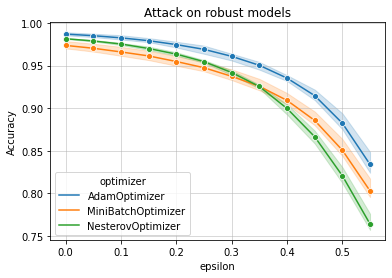

In [55]:
df_robust = pd.DataFrame(data_robust_attack).sort_values(['optimizer', 'epsilon'])
# Raw accuracy in function of attack stength
sns.lineplot(x='epsilon', y='acc', data=df, hue='optimizer', marker='o')
plt.grid(alpha=.6)
plt.ylabel('Accuracy');
plt.title('Attack on robust models');

In [60]:
df_robust.T.to_json('res/log_attack_robust.json', indent=2)

# Comparative analysis

In [6]:
# Whether to generate fancy plots for the report. Warning: this lengthens image rendering time
# This requires the `ipypublish` library
fancy_plots = False

if fancy_plots:
    from ipypublish import nb_setup
    plt = nb_setup.setup_matplotlib()
    # Override with seaborn defaults
    sns.set(style='whitegrid')